# Relax Takehome Challenge

## Goal: 
### Identify which factors predict future user adoption

#### Adopted User:
   A user who has logged into the product on three separate days in at least one seven-day period.

In [56]:
# Import the necessarry modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import pearsonr

%matplotlib inline

In [23]:
# Define adopted user parameters
period = dt.timedelta(days = 7)

In [46]:
# Read the data into two dataframes
user_engagement = pd.read_csv('takehome_user_engagement.csv', infer_datetime_format=True)
users = pd.read_csv('takehome_users.csv', infer_datetime_format=True, encoding='ISO-8859-1')
users2 = pd.read_csv('takehome_users.csv', infer_datetime_format=True, \
                    parse_dates=['creation_time', 'last_session_creation_time'], \
                    index_col='creation_time', encoding='ISO-8859-1')

user_engagement.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [47]:
users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [48]:
# get dummy variables for the creation source
creation_dummies = pd.get_dummies(users['creation_source'])

# Clean the data
users= users.drop('creation_source', axis=1).join(creation_dummies)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')

users.head(3)

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,10803.0,1,0,0,0,0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,316.0,0,1,0,0,0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1525.0,0,1,0,0,0


In [49]:
pd.to_datetime(user_engagement.time_stamp)
user_engagement.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [50]:
# Isolate the users who are possible to be identified as retained
sums = user_engagement.groupby('user_id').sum()
sums = sums[sums.visited >= 3]

# Use the index to isolate the rows from the users dataframe
users_frequent = users.loc[sums.index, :]
users_frequent.creation_time = pd.to_datetime(users_frequent.creation_time)
latest = users_frequent.last_session_creation_time.dropna().max()

# Fill the NaN values with 0 to denote the missing data
users_frequent.invited_by_user_id.fillna(0, inplace=True)
users_frequent.last_session_creation_time = pd.to_datetime(
    users_frequent.last_session_creation_time.fillna(latest))
users_frequent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2248 entries, 2 to 11991
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   2248 non-null   int64         
 1   creation_time               2248 non-null   datetime64[ns]
 2   name                        2248 non-null   object        
 3   email                       2248 non-null   object        
 4   last_session_creation_time  2248 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    2248 non-null   int64         
 6   enabled_for_marketing_drip  2248 non-null   int64         
 7   org_id                      2248 non-null   int64         
 8   invited_by_user_id          2248 non-null   float64       
 9   GUEST_INVITE                2248 non-null   uint8         
 10  ORG_INVITE                  2248 non-null   uint8         
 11  PERSONAL_PROJECTS           2248 non-null   uint8      

In [51]:
users_frequent.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,,,,
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1525.0,0,1,0,0,0
10,11,2013-12-26 03:55:00,Paulsen Malthe,MaltheAPaulsen@gustr.com,2013-12-27 03:55:54,0,0,69,0.0,0,0,0,1,0
20,21,2013-01-22 12:27:00,Hunter Alfie,AlfieHunter@gmail.com,2013-01-22 12:27:42,0,0,54,0.0,0,0,1,0,0
33,34,2014-02-03 20:55:00,Holm Sara,SaraMHolm@hotmail.com,2014-06-04 23:30:50,0,0,33,3721.0,0,1,0,0,0
42,43,2012-12-31 07:13:00,Gomes Beatrice,vgqmpljq@yyyxt.com,2013-04-15 07:13:17,0,0,63,149.0,1,0,0,0,0


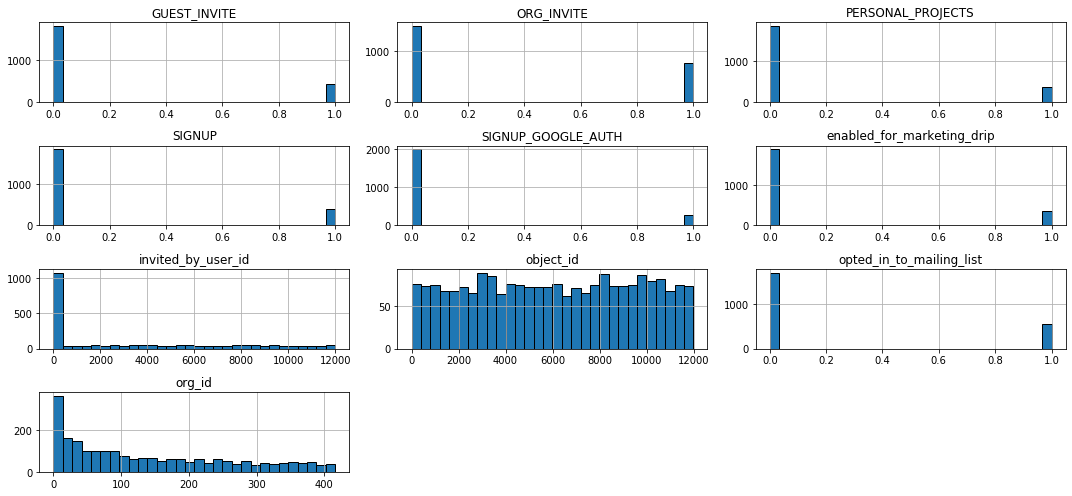

In [30]:
_=users_frequent.hist(bins=30, figsize=(15,7), edgecolor='k')
_=plt.tight_layout()

The 'invited_by_user_id' and 'org_id' columns appear to be greatly skewed. This indicates that some manner of transform on them may render them better suited for analysis purposes.

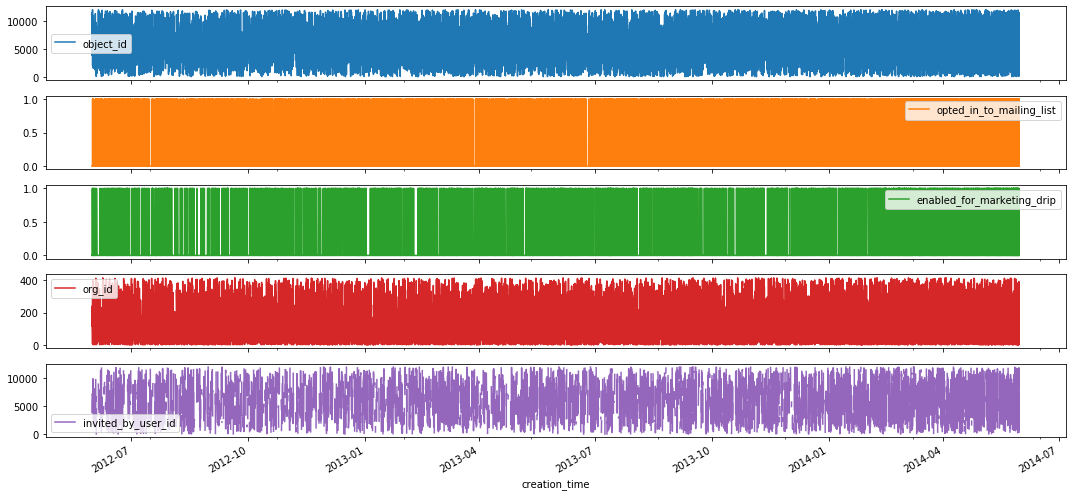

In [55]:
users2.plot(subplots=True, figsize=(15,7))
plt.tight_layout()

In [31]:
user_times = user_engagement.groupby(['user_id', 'time_stamp']).sum().loc[sums.index,:].drop('visited', axis=1)
user_times.head()

Empty DataFrame
Columns: []
Index: [(2, 2013-11-15 03:45:04), (2, 2013-11-29 03:45:04), (2, 2013-12-09 03:45:04), (2, 2013-12-25 03:45:04), (2, 2013-12-31 03:45:04)]

In [32]:
adopted_user_list = set()
for i in range(len(user_times)-1):
    user = user_times.index[i][0]
    if user in adopted_user_list:
        continue
    user_next = user_times.index[i + 1][0]
    current_time = pd.to_datetime(user_times.index[i][1])
    window = current_time + period
    if user == user_next:
        next_time = pd.to_datetime(user_times.index[i+1][1])
        if next_time < window:
            third_time = pd.to_datetime(user_times.index[i+2][1])
            if third_time < window:
                adopted_user_list.add(user)
                print('user', user, 'adopted')
        
    

user 2 adopted
user 10 adopted
user 20 adopted
user 33 adopted
user 42 adopted
user 43 adopted
user 50 adopted
user 53 adopted
user 60 adopted
user 63 adopted
user 69 adopted
user 74 adopted
user 80 adopted
user 81 adopted
user 82 adopted
user 87 adopted
user 133 adopted
user 135 adopted
user 136 adopted
user 141 adopted
user 146 adopted
user 153 adopted
user 160 adopted
user 165 adopted
user 168 adopted
user 171 adopted
user 172 adopted
user 174 adopted
user 185 adopted
user 188 adopted
user 197 adopted
user 200 adopted
user 202 adopted
user 203 adopted
user 209 adopted
user 214 adopted
user 221 adopted
user 230 adopted
user 245 adopted
user 247 adopted
user 263 adopted
user 265 adopted
user 275 adopted
user 280 adopted
user 283 adopted
user 297 adopted
user 298 adopted
user 305 adopted
user 310 adopted
user 311 adopted
user 321 adopted
user 322 adopted
user 330 adopted
user 341 adopted
user 345 adopted
user 347 adopted
user 351 adopted
user 363 adopted
user 370 adopted
user 383 adopt

user 3222 adopted
user 3226 adopted
user 3232 adopted
user 3235 adopted
user 3238 adopted
user 3239 adopted
user 3240 adopted
user 3244 adopted
user 3269 adopted
user 3273 adopted
user 3280 adopted
user 3311 adopted
user 3317 adopted
user 3324 adopted
user 3332 adopted
user 3338 adopted
user 3339 adopted
user 3346 adopted
user 3347 adopted
user 3353 adopted
user 3360 adopted
user 3370 adopted
user 3374 adopted
user 3378 adopted
user 3381 adopted
user 3387 adopted
user 3389 adopted
user 3390 adopted
user 3397 adopted
user 3405 adopted
user 3408 adopted
user 3409 adopted
user 3411 adopted
user 3426 adopted
user 3436 adopted
user 3437 adopted
user 3451 adopted
user 3463 adopted
user 3481 adopted
user 3484 adopted
user 3493 adopted
user 3502 adopted
user 3517 adopted
user 3521 adopted
user 3522 adopted
user 3525 adopted
user 3531 adopted
user 3541 adopted
user 3546 adopted
user 3556 adopted
user 3560 adopted
user 3561 adopted
user 3562 adopted
user 3564 adopted
user 3567 adopted
user 3574 

user 6321 adopted
user 6322 adopted
user 6342 adopted
user 6349 adopted
user 6350 adopted
user 6357 adopted
user 6367 adopted
user 6370 adopted
user 6388 adopted
user 6393 adopted
user 6401 adopted
user 6405 adopted
user 6416 adopted
user 6419 adopted
user 6427 adopted
user 6438 adopted
user 6462 adopted
user 6463 adopted
user 6464 adopted
user 6470 adopted
user 6482 adopted
user 6504 adopted
user 6506 adopted
user 6517 adopted
user 6532 adopted
user 6590 adopted
user 6600 adopted
user 6609 adopted
user 6617 adopted
user 6623 adopted
user 6627 adopted
user 6633 adopted
user 6637 adopted
user 6638 adopted
user 6640 adopted
user 6653 adopted
user 6654 adopted
user 6655 adopted
user 6662 adopted
user 6688 adopted
user 6705 adopted
user 6711 adopted
user 6717 adopted
user 6729 adopted
user 6731 adopted
user 6733 adopted
user 6734 adopted
user 6740 adopted
user 6741 adopted
user 6742 adopted
user 6751 adopted
user 6757 adopted
user 6759 adopted
user 6771 adopted
user 6778 adopted
user 6782 

user 9495 adopted
user 9504 adopted
user 9510 adopted
user 9532 adopted
user 9535 adopted
user 9540 adopted
user 9542 adopted
user 9558 adopted
user 9559 adopted
user 9571 adopted
user 9580 adopted
user 9582 adopted
user 9584 adopted
user 9591 adopted
user 9593 adopted
user 9597 adopted
user 9601 adopted
user 9615 adopted
user 9623 adopted
user 9635 adopted
user 9641 adopted
user 9644 adopted
user 9645 adopted
user 9652 adopted
user 9660 adopted
user 9670 adopted
user 9679 adopted
user 9683 adopted
user 9684 adopted
user 9691 adopted
user 9694 adopted
user 9695 adopted
user 9696 adopted
user 9698 adopted
user 9699 adopted
user 9717 adopted
user 9722 adopted
user 9724 adopted
user 9727 adopted
user 9728 adopted
user 9742 adopted
user 9746 adopted
user 9747 adopted
user 9750 adopted
user 9751 adopted
user 9754 adopted
user 9768 adopted
user 9771 adopted
user 9786 adopted
user 9806 adopted
user 9821 adopted
user 9823 adopted
user 9825 adopted
user 9833 adopted
user 9839 adopted
user 9841 

In [33]:
adopted_users = pd.DataFrame(adopted_user_list, columns=['adopted_users']).sort_values(by='adopted_users', ignore_index=True)
adopted_users.head()

,adopted_users
0,2
1,10
2,20
3,33
4,42


In [59]:
users['adopted_user'] = users.index.isin(adopted_users['adopted_users'])
users.drop(['creation_time', 'name', 'email', 'last_session_creation_time'], axis=1, inplace=True)
users.invited_by_user_id.fillna(0, inplace=True)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_id                      12000 non-null  int64  
 4   invited_by_user_id          12000 non-null  float64
 5   GUEST_INVITE                12000 non-null  uint8  
 6   ORG_INVITE                  12000 non-null  uint8  
 7   PERSONAL_PROJECTS           12000 non-null  uint8  
 8   SIGNUP                      12000 non-null  uint8  
 9   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
 10  adopted_user                12000 non-null  bool   
dtypes: bool(1), float64(1), int64(4), uint8(5)
memory usage: 539.2 KB


<Figure size 1080x504 with 0 Axes>

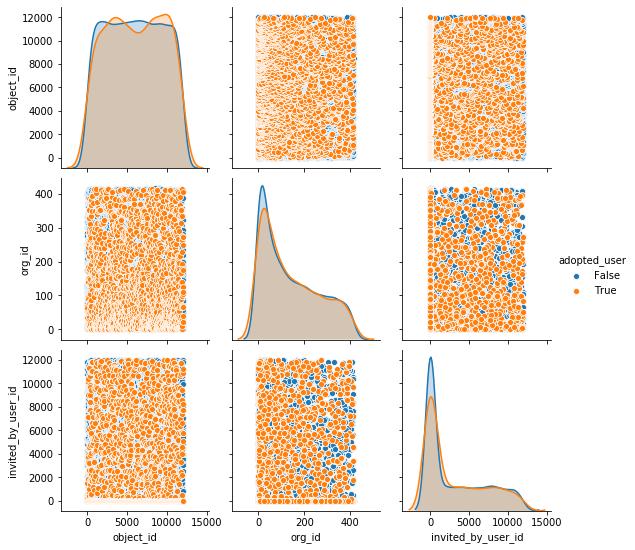

In [60]:
_=plt.figure(figsize=(15,7))
_=sns.pairplot(users[['object_id', 'org_id', 'invited_by_user_id', 'adopted_user']], hue='adopted_user')

In [67]:
users.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,adopted_user
0,1,1,0,11,10803.0,1,0,0,0,0,False
1,2,0,0,1,316.0,0,1,0,0,0,False
2,3,0,0,94,1525.0,0,1,0,0,0,True
3,4,0,0,1,5151.0,1,0,0,0,0,False
4,5,0,0,193,5240.0,1,0,0,0,0,False


In [79]:
pearsonr(users['invited_by_user_id'], users['adopted_user'])

(-0.006208264929214651, 0.496493661175933)

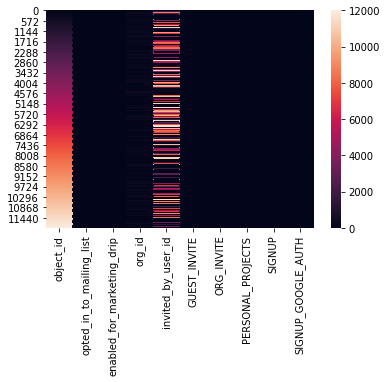

In [80]:
_=sns.heatmap(users.drop(['adopted_user'], axis=1))

# Conclusion


Exploratory data visualization showed little in respect to identifyting the factors which predict user adoption. A straightforward way to tell statistical significance is to use the Pearson correlation coefficient.